## Feature Selection

Topics for this notebook
1. Clinical context  
2. Read in CSV file
3. Correct the data types for the model  
4. Spitting the data between training and testing sets
5. Oversampling to make the training set more balanced  
6. Feature selection using a wrapper method
7. Feature selection using an embedded method 

## Clinical context   

For this notebook we will be building a model to predict hospital death based on data from an intensive care unit (ICU). Predicting patient death in the ICU is extremely important because determining which patients needs attention immediately can help to prioritize care in a way that prevents as many deaths as possible. As a basis for this model we will be selecting many of the same features used by the Apache Algorithm. The Apache Algorithm was also created to predict patient death in the ICU and should serve as a good starting point for our model. Due to some missing data, certain features from the Apache Algorithm have been excluded from our model. Also, in an attempt to increase the performance of our model new features have been added that are not part of the Apache Algorithm.

## How to run this module


Throughout this module you will encounter both text and code cells. Please run each cell in this Notebook by clicking "Run" button in the Toolbar or by pushing Shift+Enter keys
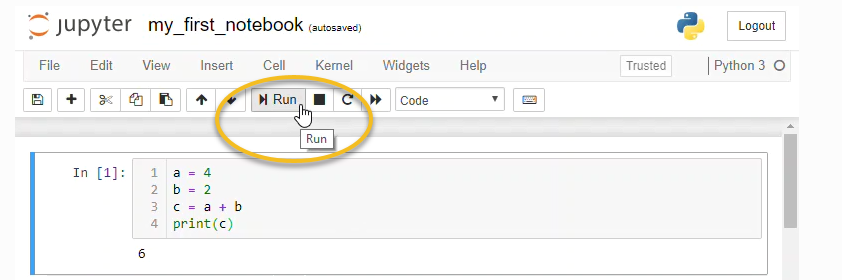

The cell above is an example of a code cell. You will be running numerous code cells like the one below throughout the case. Select the cell and select the run button above. 

In [ ]:
# This is an example of a code cell
print('Congratulations!')
print('You\'ve run your first code cell.')

## Please click the image below to open the video lecture for this module 

[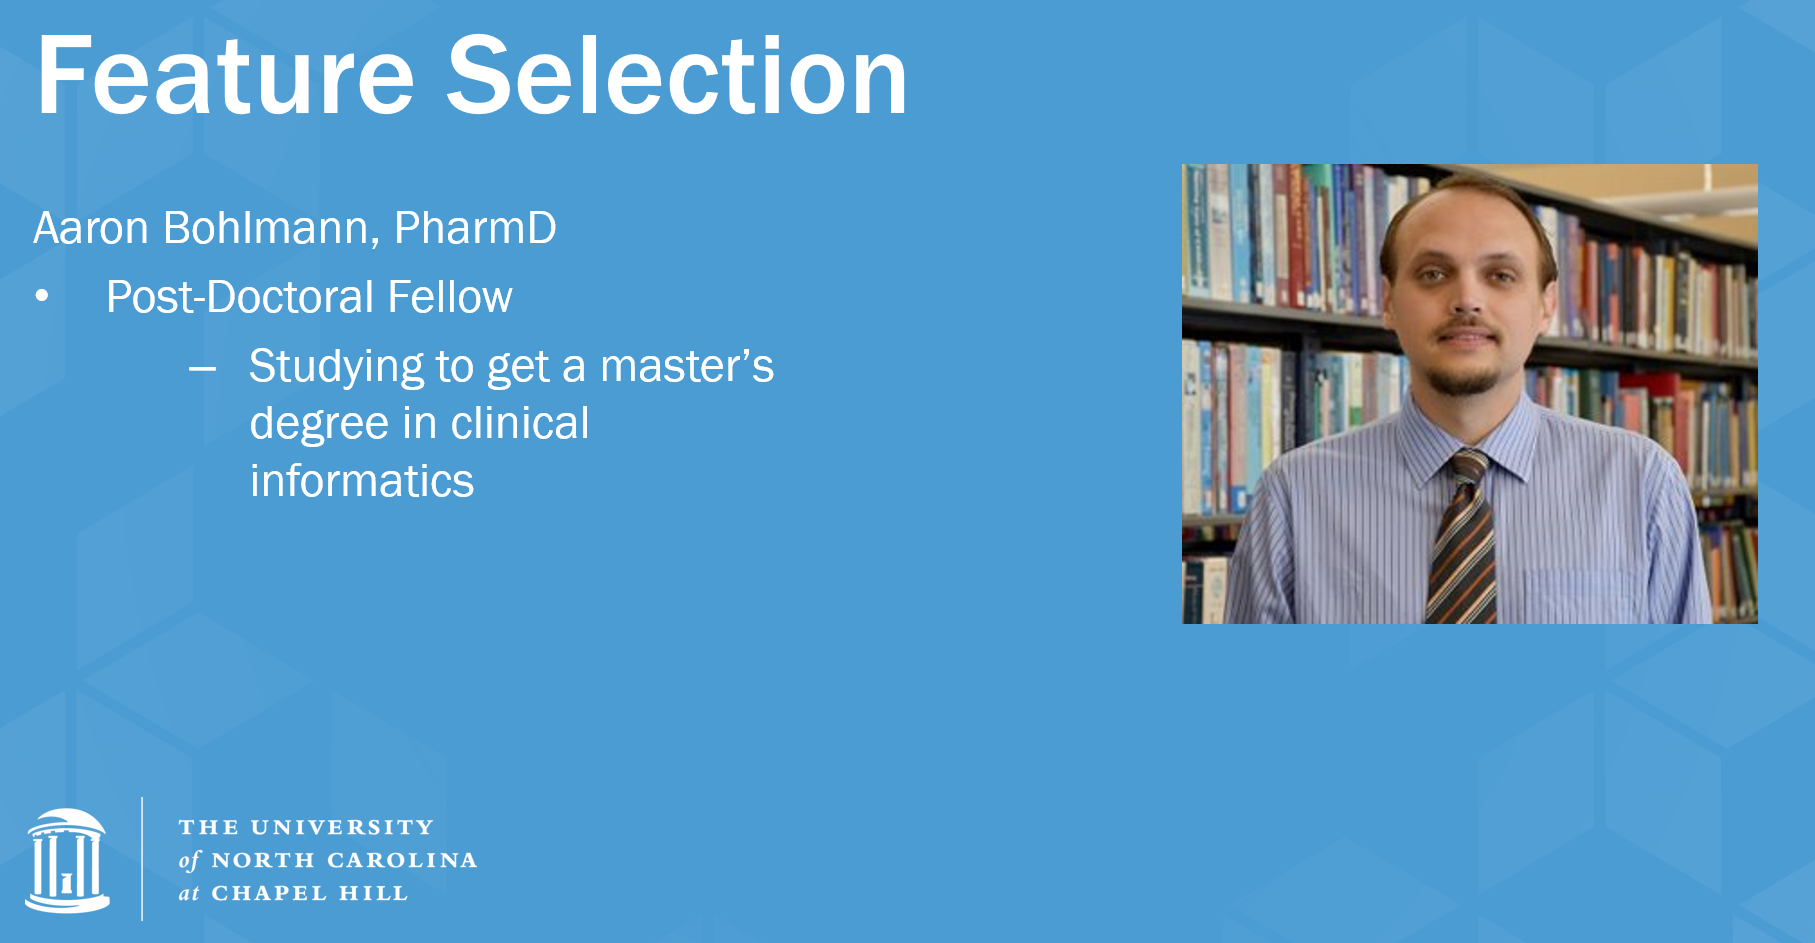](https://www.youtube.com/embed/yjzDvfVR2mg?list=PL6IN6GlGifEytPcv5HR_iaNBekwXYZIpR "Feature Selection")

## Read in CSV file 

In [ ]:
options(readr.show_col_types=FALSE)

#install and load required libraries/packages 
library (rlang)
library (readr)

#location of raw csv file on github repository 
urlfile="https://raw.githubusercontent.com/e-cui/ENABLE-HiDAV-Online-Modules/master/Data%20Mining%20Modules/csv_files/t.csv"

#Read the CSV file into a data frame called t 
t<-read_csv(url(urlfile))

#print
print("CSV file loaded sucessfully")

## Change data type to fit the model 

- In order for the model to behave properly the correct data types must be assigned to each of our variables.
- One issue with using CSV files is that they do not specify the data type so this step is often required before extensive data manipulation.

In [ ]:
#change categorical variables to factor data type
#data_frame$column_name is used to refer to a specific column
t$hospital_death<- as.factor(t$hospital_death)
t$sepsis<- as.factor(t$sepsis)
t$cardiovascular_diagnosis<- as.factor(t$cardiovascular_diagnosis)
t$intubated_apache<- as.factor(t$intubated_apache)
t$gcs_eyes_apache<- as.factor(t$gcs_eyes_apache)
t$gcs_motor_apache<- as.factor(t$gcs_motor_apache)

#change to numeric variables to numeric data type 
t$temp_apache<- as.numeric(t$temp_apache)
t$map_apache<- as.numeric(t$map_apache)
t$h1_heartrate_max<- as.numeric(t$h1_heartrate_max)
t$d1_resprate_max<- as.numeric(t$d1_resprate_max)
t$d1_potassium_max<- as.numeric(t$d1_potassium_max)
t$d1_creatinine_max<- as.numeric(t$d1_creatinine_max)
t$d1_hematocrit_max<- as.numeric(t$d1_hematocrit_max)
t$sodium_apache<- as.numeric(t$sodium_apache)
t$wbc_apache<- as.numeric(t$wbc_apache)
t$age<- as.numeric(t$age)
t$pre_icu_los_days<- as.numeric(t$pre_icu_los_days)
t$bmi<- as.numeric(t$bmi)

#check all variable data types to make sure they are correct
str(t)

## Split the data frame into separate training and testing data frames

- Splitting the data in this manner is important because the model must be tested on data that it has never seen before. 
- When splitting the data the training set should be larger than the testing to allow for more accurate predictions.

In [ ]:
#install and load required libraries/packages 
library(caTools)

#75% of the sample size
smp_size <- floor(0.75 * nrow(t))

#set the seed to make your partition reproducible
set.seed(123)
train_ind <- sample(seq_len(nrow(t)), size = smp_size)

#create a training data frame and a testing data frame 
train1 <- t[train_ind, ]
test1 <- t[-train_ind, ]

#print
print("Training and testing data sets created")

## Oversample the minority outcome to balance the training data frame (not always necessary)  

- Oversampling was necessary for this case since death is much less common in the ICU than recovery. 
- Without oversampling our algorithm may predict that no patient would die. 

In [ ]:
#install and load required libraries/packages 
library(ROSE)

#oversample the minority outcome to correct for data imbalance
data.rose <- ROSE(hospital_death~., p = 0.4, data=test1, seed=3)$data

#show how many of each outcome in oversampled data 
table(data.rose$hospital_death)

## Backward feature selection using recursive feature elimination (wrapper method)

- Backward feature selection starts with all the variables included in the model. 
- The model is run many times as the number of features are reduced. 
- After completion, backward feature selection will specify the optimal number of features for your model. 

In [ ]:
#feature selection using recursive feature elimination(rfe) 
#backward feature selection starts with all features then reduces the number of features 
#install and load required packages/libraries 
library(e1071)
library(mlbench)
library(caret)
library(randomForest)

#establish training parameters
rfe_training <- rfeControl(functions=rfFuncs, method="cv", number=10)

#run the rfe model using the oversampled training data 
rfe <- rfe(data.rose[,2:18], data.rose[,1], sizes=c(2:18), rfeControl=rfe_training)
print(rfe)

#show variable rank
predictors(rfe) 

#display graph that highlights the most accurate number of features
plot(rfe, type=c("g", "o"))

## Feature selection using a random forest algorithm (embedded method)

- Random forest automatically selects features for the decision trees that it uses to make predictions. 
- The different decision trees are created using slightly different variables and features for each tree resulting in a forest where each tree behaves in a unique manner. 

In [ ]:
#install and load required libraries/packages 
library(e1071)
library(mlbench)
library(caret)
library(randomForest)

#establish the training parameters 
t_training<- trainControl(method = "repeatedcv", number=10, repeats=3)
seed<- 7
metric<- "Accuracy"
set.seed(seed)
mtry<- sqrt(ncol(data.rose))
tunegrid<-expand.grid(.mtry=mtry)

#train the random forest algorithm on the oversampled training data 
#the oversampled training data frame is called data.rose 
#the outcome variable is hospital death
t_model<- train(hospital_death~., data=data.rose, method="rf", metric=metric, tuneGrid=tunegrid, trControl=t_training)

#show the results of model training
print(t_model)

#apply the trained model to the unseen testing data frame and store the results as z  
z<- predict(t_model, test1)

#look at the results of running the model with unseen test data using a confusion matrix 
confusionMatrix(z, test1$hospital_death)

#visualize variable importance 
variable_importance<- varImp(t_model)
print(variable_importance)

## Conclusion 

- The following key questions were addressed during this notebook and the accompanying video lecture:
1. What are the three main types of methods used for feature selection?
2. What are the advantages and disadvantages of the feature selection approaches mentioned?